In [1]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.evaluation import evaluate_policy
import tensorflow as tf
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.bench.monitor import Monitor
from stable_baselines.common.callbacks import EveryNTimesteps

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import gym
import w_mac
from collections import defaultdict
import matplotlib as plt
import networkx as nx
import dill
from copy import deepcopy
from ray import tune

defaultdict(<class 'list'>, {0: [2, 1, 3], 1: [2, 3], 2: [3, 4], 3: [4], 5: [2, 3, 4]})


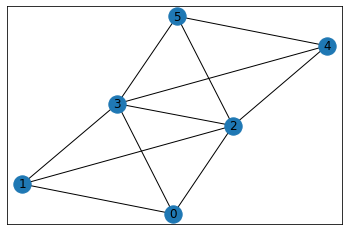

In [3]:

# data = [(0,2),(0,1),(1,2),(2,3),(2,4),(3,4)]
#data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4),(5,6),(6,7),(6,8),(7,8),(8,9),(9,10),(4,10)]#(4,6),(5,10),(6,10),(9,6),(8,10)]
d = defaultdict(list)
data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4)]
for node, dest in data:
    d[node].append(dest)
print(d)

G = nx.Graph()
for k,v in d.items():
    for vv in v:
        G.add_edge(k,vv)
nx.draw_networkx(G)

In [4]:
env = gym.make('wmac-graph-v0',graph=G)
#env = gym.make('wmac-tune-v0')
env.reset()

array([5, 0, 6, 5, 3, 3, 1])

In [5]:
check_env(env)

In [6]:
assert(dill.pickles(env))

In [7]:
"""
def evaluate_objective(config):
    tune_env = deepcopy(env)
    tune_agent = A2C("MlpPolicy", tune_env, learning_rate= config["lr"] )
    tune_agent.learn(total_timesteps=10)
    
    mean_reward, std_reward = evaluate_policy(tune_agent, env, n_eval_episodes=10, render=False,
                                                           deterministic=True,
                                                           return_episode_rewards=False)
    print("mr",mean_reward,"sd", std_reward)
    tune.report(mean_reward=mean_reward)
"""

'\ndef evaluate_objective(config):\n    tune_env = deepcopy(env)\n    tune_agent = A2C("MlpPolicy", tune_env, learning_rate= config["lr"] )\n    tune_agent.learn(total_timesteps=10)\n    \n    mean_reward, std_reward = evaluate_policy(tune_agent, env, n_eval_episodes=10, render=False,\n                                                           deterministic=True,\n                                                           return_episode_rewards=False)\n    print("mr",mean_reward,"sd", std_reward)\n    tune.report(mean_reward=mean_reward)\n'

In [8]:
import numpy as np
from typing import Union
from ray.tune import report
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.vec_env import DummyVecEnv, VecEnv, sync_envs_normalization

class OptimizationCallback(BaseCallback):

    def __init__(self, eval_env: Union[gym.Env, VecEnv],
                 n_eval_episodes: int = 5,
                 deterministic: bool = True,
                 verbose=0):
        super(OptimizationCallback, self).__init__(verbose)
        self.eval_env = deepcopy(eval_env)
        self.eval_env.reset()
        self.n_eval_episodes = n_eval_episodes
        self.deterministic = deterministic

    def _on_step(self):
        #sync_envs_normalization(self.training_env, self.eval_env)

        episode_rewards, episode_lengths = evaluate_policy(self.model, self.eval_env,
                                                           n_eval_episodes=self.n_eval_episodes,
                                                           render=False,
                                                           deterministic=self.deterministic,
                                                           return_episode_rewards=True)

        mean_reward= np.mean(episode_rewards)
        mean_ep_length = np.mean(episode_lengths)
        packet_lost = self.eval_env.get_packet_lost()

        report(
            mean_reward=mean_reward,
            mean_ep_length=mean_ep_length,
            packet_lost = packet_lost
        )

In [9]:
"""
import ray

object_store_memory = int(0.3 * ray.utils.get_system_memory() // 10 ** 9 * 10 ** 9)
ray.init(
            ignore_reinit_error=True,
            num_cpus = 10,
            local_mode = True,
            _plasma_directory="/tmp",
            object_store_memory=object_store_memory,
        )
"""

'\nimport ray\n\nobject_store_memory = int(0.3 * ray.utils.get_system_memory() // 10 ** 9 * 10 ** 9)\nray.init(\n            ignore_reinit_error=True,\n            num_cpus = 10,\n            local_mode = True,\n            _plasma_directory="/tmp",\n            object_store_memory=object_store_memory,\n        )\n'

In [10]:
from ray import tune
from ray.tune.suggest.ax import AxSearch
from ray.tune.schedulers import ASHAScheduler
parameters=[
    {"name": "learning_rate", "type": "range", "bounds": [3e-5, 3e-3]},
    {"name": "gamma", "type": "range", "bounds": [0.99, 1.0]},
    {"name": "max_grad_norm", "type": "range", "bounds": [0.3, 7.0]}
]   

        
def evaluate_objective(config):
    tune_env = deepcopy(env)
    tune_monitor = OptimizationCallback(tune_env, 5, True)
    monitor_callback = EveryNTimesteps(n_steps=1000, callback=tune_monitor)

    
    
    tune_agent = A2C("MlpPolicy", tune_env, 
                     gamma = config["gamma"],
                     max_grad_norm = config["max_grad_norm"],
                     learning_rate= config["learning_rate"]
                    )#**config)
    tune_agent.learn(total_timesteps=400000, callback=monitor_callback)
    
ax_search = AxSearch(space=parameters, metric="mean_reward", mode = "max")

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='mean_reward',
    mode='max',
    max_t=100,
    grace_period=10,
    reduction_factor=3,
    brackets=1)

analysis = tune.run(evaluate_objective,
         num_samples=5,
         search_alg=ax_search,
         scheduler=asha_scheduler,
         resources_per_trial={"cpu": 8}
        )

[INFO 12-15 23:13:32] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 12-15 23:13:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-15 23:13:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter gamma. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-15 23:13:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter max_grad_norm. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-15

Trial name,status,loc,gamma,learning_rate,max_grad_norm
evaluate_objective_c575fb02,RUNNING,,0.990228,0.00064491,3.14781
evaluate_objective_c575fb03,PENDING,,0.992424,0.000166578,4.45429
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207


(pid=26224) WARNING:tensorflow:
(pid=26224) The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=26224) For more information, please see:
(pid=26224)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=26224)   * https://github.com/tensorflow/addons
(pid=26224)   * https://github.com/tensorflow/io (for I/O related ops)
(pid=26224) If you depend on functionality not listed there, please file an issue.
(pid=26224) 
(pid=26235) WARNING:tensorflow:
(pid=26235) The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=26235) For more information, please see:
(pid=26235)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=26235)   * https://github.com/tensorflow/addons
(pid=26235)   * https://github.com/tensorflow/io (for I/O related ops)
(pid=26235) If you depend on functionality not listed there, please file an issue.
(pid=26235) 
(pid=26235) WARNING:tensorflow:From /hom

(pid=26235) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:160: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.
(pid=26235) 
(pid=26235) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:160: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.
(pid=26235) 
(pid=26235) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:449: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.
(pid=26235) 
(pid=26235) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:449: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.
(pid=26235) 
(pid=26235) WARNING:tensorflow:From /home/aicon/an

(pid=26224) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:194: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.
(pid=26224) 
(pid=26224) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:194: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.
(pid=26224) 
(pid=26235) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:196: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.
(pid=26235) 
(pid=26235) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:196: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.
(pid=2623

Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-13-43
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 1
  mean_ep_length: 482.8
  mean_reward: -264797.0
  node_ip: 131.234.29.24
  packet_lost: 25
  pid: 26224
  time_since_restore: 6.5308308601379395
  time_this_iter_s: 6.5308308601379395
  time_total_s: 6.5308308601379395
  timestamp: 1608070423
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,,0.990228,0.00064491,3.14781,,,,,
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,1,6.53083,-264797,482.8,25
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-13-44
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 1
  mean_ep_length: 602.0
  mean_reward: -12819.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 7.123113393783569
  time_this_iter_s: 7.123113393783569
  time_total_s: 7.123113393783569
  timestamp: 1608070424
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-13-51
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 3
  mean_ep_length: 366.6
  mean_reward: -36010.2
  node_ip: 131.234.29.24
  packet_lost: 15
  pid: 26224
  time_since_restore: 14.475023031234741
  time_this_iter_s: 3.6082608699798584
  time_total_s: 14.475023031234741
  timestamp: 1608070431
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,2,11.5142,-5370.2,602,13
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,3,14.475,-36010.2,366.6,15
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-13-53
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 3
  mean_ep_length: 602.0
  mean_reward: -177761.4
  node_ip: 131.234.29.24
  packet_lost: 14
  pid: 26235
  time_since_restore: 16.120899438858032
  time_this_iter_s: 4.606675148010254
  time_total_s: 16.120899438858032
  timestamp: 1608070433
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,4,20.7026,-27264.8,602,14
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,4,19.1454,-149706,602,23
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-01
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 5
  mean_ep_length: 602.0
  mean_reward: -318944.0
  node_ip: 131.234.29.24
  packet_lost: 16
  pid: 26224
  time_since_restore: 24.02467179298401
  time_this_iter_s: 4.879225254058838
  time_total_s: 24.02467179298401
  timestamp: 1608070441
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-02
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 5
  mean_ep_length: 602.0
  mean_reward: -27114.4
  node_ip: 131.234.29.24
  packet_lost: 17
  pid: 26235
  time_since_restore: 25.3732807636261
  time_this_iter_s: 4.670637369155884
  time_total_s: 25.3732807636261
  timestamp: 1608070442
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,5,25.3733,-27114.4,602,17
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,6,28.5111,-143792,602,18
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-10
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 7
  mean_ep_length: 602.0
  mean_reward: -316601.2
  node_ip: 131.234.29.24
  packet_lost: 7
  pid: 26224
  time_since_restore: 33.04163122177124
  time_this_iter_s: 4.5305328369140625
  time_total_s: 33.04163122177124
  timestamp: 1608070450
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-11
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 7
  mean_ep_length: 602.0
  mean_reward: -13541.4
  node_ip: 131.234.29.24
  packet_lost: 9
  pid: 26235
  time_since_restore: 34.42863965034485
  time_this_iter_s: 4.6291913986206055
  time_total_s: 34.42863965034485
  timestamp: 1608070451
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,7,34.4286,-13541.4,602,9
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,7,33.0416,-316601,602,7
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-18
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 9
  mean_ep_length: 602.0
  mean_reward: -13743.2
  node_ip: 131.234.29.24
  packet_lost: 2
  pid: 26224
  time_since_restore: 41.87111830711365
  time_this_iter_s: 4.268448114395142
  time_total_s: 41.87111830711365
  timestamp: 1608070458
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,8,38.8812,-4680.8,602,11
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,9,41.8711,-13743.2,602,2
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-20
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 9
  mean_ep_length: 602.0
  mean_reward: -2641.2
  node_ip: 131.234.29.24
  packet_lost: 9
  pid: 26235
  time_since_restore: 43.32884931564331
  time_this_iter_s: 4.447674036026001
  time_total_s: 43.32884931564331
  timestamp: 1608070460
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,10,47.8516,-2064.6,602,5
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,10,46.3541,-26803.4,602,14
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-27
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 11
  mean_ep_length: 602.0
  mean_reward: -157144.2
  node_ip: 131.234.29.24
  packet_lost: 10
  pid: 26224
  time_since_restore: 50.78362250328064
  time_this_iter_s: 4.429565668106079
  time_total_s: 50.78362250328064
  timestamp: 1608070467
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-29
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 11
  mean_ep_length: 602.0
  mean_reward: -2212.2
  node_ip: 131.234.29.24
  packet_lost: 13
  pid: 26235
  time_since_restore: 52.22571396827698
  time_this_iter_s: 4.374143362045288
  time_total_s: 52.22571396827698
  timestamp: 1608070469
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,11,52.2257,-2212.2,602,13
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,12,55.289,-81104.4,602,5
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-36
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 13
  mean_ep_length: 602.0
  mean_reward: -2419.2
  node_ip: 131.234.29.24
  packet_lost: 2
  pid: 26224
  time_since_restore: 59.81099033355713
  time_this_iter_s: 4.522005796432495
  time_total_s: 59.81099033355713
  timestamp: 1608070476
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-38
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 13
  mean_ep_length: 602.0
  mean_reward: -3327.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 61.1561119556427
  time_this_iter_s: 4.529921770095825
  time_total_s: 61.1561119556427
  timestamp: 1608070478
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,13,61.1561,-3327,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,13,59.811,-2419.2,602,2
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-45
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 15
  mean_ep_length: 602.0
  mean_reward: -12736.8
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 68.84430193901062
  time_this_iter_s: 4.529452085494995
  time_total_s: 68.84430193901062
  timestamp: 1608070485
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,14,65.4965,-1967.4,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,15,68.8443,-12736.8,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-46
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 15
  mean_ep_length: 602.0
  mean_reward: -1942.2
  node_ip: 131.234.29.24
  packet_lost: 4
  pid: 26235
  time_since_restore: 69.77798295021057
  time_this_iter_s: 4.281516075134277
  time_total_s: 69.77798295021057
  timestamp: 1608070486
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,16,74.0008,-1914,602,5
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,16,73.4481,-23272.8,602,8
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-14-54
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 17
  mean_ep_length: 602.0
  mean_reward: -12762.6
  node_ip: 131.234.29.24
  packet_lost: 3
  pid: 26224
  time_since_restore: 77.83147644996643
  time_this_iter_s: 4.383368730545044
  time_total_s: 77.83147644996643
  timestamp: 1608070494
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-14-55
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 17
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 78.39140582084656
  time_this_iter_s: 4.390631437301636
  time_total_s: 78.39140582084656
  timestamp: 1608070495
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,17,78.3914,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,18,82.1955,-1945.8,602,5
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-04
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 19
  mean_ep_length: 602.0
  mean_reward: -3009.0
  node_ip: 131.234.29.24
  packet_lost: 1
  pid: 26224
  time_since_restore: 86.96818232536316
  time_this_iter_s: 4.77265477180481
  time_total_s: 86.96818232536316
  timestamp: 1608070504
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: c575fb03
  
Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-04
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 19
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 87.0649528503418
  time_this_iter_s: 

(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,19,87.065,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,20,91.3808,-22876.2,602,5
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-12
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 21
  mean_ep_length: 602.0
  mean_reward: -2802.0
  node_ip: 131.234.29.24
  packet_lost: 12
  pid: 26224
  time_since_restore: 95.91151404380798
  time_this_iter_s: 4.5306689739227295
  time_total_s: 95.91151404380798
  timestamp: 1608070512
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: c575fb03
  
Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-13
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 21
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 96.03535628318787
  time_this_iter

(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,21,96.0354,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,22,100.379,-1955.4,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-21
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 23
  mean_ep_length: 602.0
  mean_reward: -2854.2
  node_ip: 131.234.29.24
  packet_lost: 4
  pid: 26224
  time_since_restore: 104.88011336326599
  time_this_iter_s: 4.501288652420044
  time_total_s: 104.88011336326599
  timestamp: 1608070521
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: c575fb03
  
Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-22
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 23
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 104.97676539421082
  time_this_ite

(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,23,104.977,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,24,109.376,-12351.6,602,4
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-30
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 25
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 113.89241337776184
  time_this_iter_s: 4.4300596714019775
  time_total_s: 113.89241337776184
  timestamp: 1608070530
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: c575fb02
  
Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-30
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 25
  mean_ep_length: 602.0
  mean_reward: -1871.4
  node_ip: 131.234.29.24
  packet_lost: 4
  pid: 26224
  time_since_restore: 113.90576124191284
  time_this_it

(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,25,113.892,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,26,118.169,-1833,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-39
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 27
  mean_ep_length: 602.0
  mean_reward: -1857.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 122.5251727104187
  time_this_iter_s: 4.356276273727417
  time_total_s: 122.5251727104187
  timestamp: 1608070539
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: c575fb03
  
Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-39
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 27
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 122.58498406410217
  time_this_iter_

(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,28,127.106,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,27,122.525,-1857,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-48
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 29
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 131.44628047943115
  time_this_iter_s: 4.3404974937438965
  time_total_s: 131.44628047943115
  timestamp: 1608070548
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-48
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 29
  mean_ep_length: 602.0
  mean_reward: -1827.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 131.72425866127014
  time_this_iter_s: 4.5763325691223145
  time_total_s: 131.72425866127014
  timestamp: 1608070548
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,30,135.815,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,29,131.724,-1827,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-15-57
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 31
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 140.21993494033813
  time_this_iter_s: 4.404754161834717
  time_total_s: 140.21993494033813
  timestamp: 1608070557
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: c575fb02
  
Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-15-57
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 31
  mean_ep_length: 602.0
  mean_reward: -1836.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 140.60267233848572
  time_this_ite

(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,32,144.689,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,31,140.603,-1836,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-16-06
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 33
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 149.11305022239685
  time_this_iter_s: 4.423608064651489
  time_total_s: 149.11305022239685
  timestamp: 1608070566
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: c575fb02
  
Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-16-06
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 33
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 149.24599528312683
  time_this_ite

(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,33,149.113,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,34,153.434,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-16-14
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 35
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 157.89743828773499
  time_this_iter_s: 4.463358402252197
  time_total_s: 157.89743828773499
  timestamp: 1608070574
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: c575fb03
  
Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-16-15
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 35
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 157.98382711410522
  time_this_ite

(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,36,162.54,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,35,157.897,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-16-24
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 37
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 167.13818645477295
  time_this_iter_s: 4.556173324584961
  time_total_s: 167.13818645477295
  timestamp: 1608070584
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-16-24
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 37
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 167.40278601646423
  time_this_iter_s: 4.862726449966431
  time_total_s: 167.40278601646423
  timestamp: 1608070584
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,37,167.403,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,38,171.647,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-16-33
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 39
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 176.20706605911255
  time_this_iter_s: 4.559732913970947
  time_total_s: 176.20706605911255
  timestamp: 1608070593
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: c575fb03
  
Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-16-33
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 39
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 176.67280054092407
  time_this_ite

Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,39,176.673,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,39,176.207,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-16-42
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 41
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 185.22063493728638
  time_this_iter_s: 4.505255937576294
  time_total_s: 185.22063493728638
  timestamp: 1608070602
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,40,181.187,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,41,185.221,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-16-42
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 41
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 185.80019164085388
  time_this_iter_s: 4.61339259147644
  time_total_s: 185.80019164085388
  timestamp: 1608070602
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-16-51
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 43
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 194.25761604309082
  time_this_iter_s: 4.270889520645142
  time_total_s: 194.25761604309082
  timestamp: 1608070611
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,43,194.258,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,42,189.852,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-16-51
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 43
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 194.39806413650513
  time_this_iter_s: 4.54594349861145
  time_total_s: 194.39806413650513
  timestamp: 1608070611
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-00
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 45
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 203.40376210212708
  time_this_iter_s: 4.428539276123047
  time_total_s: 203.40376210212708
  timestamp: 1608070620
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,44,198.851,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,45,203.404,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-00
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 45
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 203.42578125
  time_this_iter_s: 4.574492454528809
  time_total_s: 203.42578125
  timestamp: 1608070620
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-09
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 47
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 212.31288123130798
  time_this_iter_s: 4.32453727722168
  time_total_s: 212.31288123130798
  timestamp: 1608070629
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,47,212.313,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,46,207.872,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-09
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 47
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 212.37111616134644
  time_this_iter_s: 4.4991724491119385
  time_total_s: 212.37111616134644
  timestamp: 1608070629
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-18
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 49
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 221.1272087097168
  time_this_iter_s: 4.463316440582275
  time_total_s: 221.1272087097168
  timestamp: 1608070638
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,49,221.127,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,48,216.837,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-18
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 49
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 221.2133629322052
  time_this_iter_s: 4.3764424324035645
  time_total_s: 221.2133629322052
  timestamp: 1608070638
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-26
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 51
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 229.93159341812134
  time_this_iter_s: 4.453614950180054
  time_total_s: 229.93159341812134
  timestamp: 1608070646
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,50,225.744,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,51,229.932,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-27
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 51
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 230.15204215049744
  time_this_iter_s: 4.407711744308472
  time_total_s: 230.15204215049744
  timestamp: 1608070647
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-35
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 53
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 238.81747889518738
  time_this_iter_s: 4.4879419803619385
  time_total_s: 238.81747889518738
  timestamp: 1608070655
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,52,234.476,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,53,238.817,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-35
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 53
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 238.89405131340027
  time_this_iter_s: 4.418180465698242
  time_total_s: 238.89405131340027
  timestamp: 1608070655
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: c575fb02
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-44
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 55
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 247.57134366035461
  time_this_iter_s: 4.3281943798065186
  time_total_s: 247.57134366035461
  timestamp: 1608070664
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,55,247.571,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,54,243.145,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-44
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 55
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 247.64891529083252
  time_this_iter_s: 4.504237174987793
  time_total_s: 247.64891529083252
  timestamp: 1608070664
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-17-53
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 57
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 256.23436164855957
  time_this_iter_s: 4.414580821990967
  time_total_s: 256.23436164855957
  timestamp: 1608070673
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,56,251.925,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,57,256.234,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-17-53
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 57
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 256.27151250839233
  time_this_iter_s: 4.346451759338379
  time_total_s: 256.27151250839233
  timestamp: 1608070673
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: c575fb02
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-01
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 59
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 264.71788454055786
  time_this_iter_s: 4.2586870193481445
  time_total_s: 264.71788454055786
  timestamp: 1608070681
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,58,260.656,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,59,264.718,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-02
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 59
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 265.03724455833435
  time_this_iter_s: 4.381702184677124
  time_total_s: 265.03724455833435
  timestamp: 1608070682
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-10
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 61
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 273.4232370853424
  time_this_iter_s: 4.254491806030273
  time_total_s: 273.4232370853424
  timestamp: 1608070690
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,60,269.259,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,61,273.423,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-10
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 61
  mean_ep_length: 602.0
  mean_reward: -1837.2
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 273.5092167854309
  time_this_iter_s: 4.250411033630371
  time_total_s: 273.5092167854309
  timestamp: 1608070690
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: c575fb02
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-19
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 63
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 282.1098449230194
  time_this_iter_s: 4.329556226730347
  time_total_s: 282.1098449230194
  timestamp: 1608070699
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: c575fb02
  


(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,63,282.11,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,62,277.96,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-19
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 63
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 282.55274081230164
  time_this_iter_s: 4.593014240264893
  time_total_s: 282.55274081230164
  timestamp: 1608070699
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,64,286.519,-1829.4,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,64,287.197,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-28
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 65
  mean_ep_length: 602.0
  mean_reward: -1837.2
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 290.9966447353363
  time_this_iter_s: 4.477212190628052
  time_total_s: 290.9966447353363
  timestamp: 1608070708
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-28
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 65
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 291.78958773612976
  time_this_iter_s: 4.59224009513855
  time_total_s: 291.78958773612976
  timestamp: 1608070708
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,66,295.421,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,65,291.79,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-36
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 67
  mean_ep_length: 602.0
  mean_reward: -1829.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 299.8300702571869
  time_this_iter_s: 4.409566164016724
  time_total_s: 299.8300702571869
  timestamp: 1608070716
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-37
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 67
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 300.52569460868835
  time_this_iter_s: 4.370903253555298
  time_total_s: 300.52569460868835
  timestamp: 1608070717
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: c575fb03
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,67,299.83,-1829.4,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,67,300.526,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-45
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 69
  mean_ep_length: 602.0
  mean_reward: -1830.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 308.3144805431366
  time_this_iter_s: 4.178035497665405
  time_total_s: 308.3144805431366
  timestamp: 1608070725
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,69,308.314,-1830,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,68,304.741,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-46
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 69
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 309.0075480937958
  time_this_iter_s: 4.2668516635894775
  time_total_s: 309.0075480937958
  timestamp: 1608070726
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-18-54
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 71
  mean_ep_length: 602.0
  mean_reward: -1848.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 316.9866728782654
  time_this_iter_s: 4.354377031326294
  time_total_s: 316.9866728782654
  timestamp: 1608070734
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: c575fb02
  


(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,71,316.987,-1848,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,70,313.232,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-18-54
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 71
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 317.43401622772217
  time_this_iter_s: 4.202315807342529
  time_total_s: 317.43401622772217
  timestamp: 1608070734
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-02
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 73
  mean_ep_length: 602.0
  mean_reward: -1837.2
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 325.4793031215668
  time_this_iter_s: 4.219974994659424
  time_total_s: 325.4793031215668
  timestamp: 1608070742
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: c575fb02
  


(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,73,325.479,-1837.2,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,72,321.765,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-03
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 73
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 325.9722421169281
  time_this_iter_s: 4.207194566726685
  time_total_s: 325.9722421169281
  timestamp: 1608070743
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-10
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 75
  mean_ep_length: 602.0
  mean_reward: -1837.2
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 333.8312623500824
  time_this_iter_s: 4.19485330581665
  time_total_s: 333.8312623500824
  timestamp: 1608070750
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,75,333.831,-1837.2,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,74,330.244,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-11
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 75
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 334.5128710269928
  time_this_iter_s: 4.268635034561157
  time_total_s: 334.5128710269928
  timestamp: 1608070751
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-19
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 77
  mean_ep_length: 602.0
  mean_reward: -1821.6
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 342.309766292572
  time_this_iter_s: 4.305419921875
  time_total_s: 342.309766292572
  timestamp: 1608070759
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,77,342.31,-1821.6,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,76,338.732,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-19
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 77
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 342.93780994415283
  time_this_iter_s: 4.205798625946045
  time_total_s: 342.93780994415283
  timestamp: 1608070759
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: c575fb03
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-27
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 79
  mean_ep_length: 602.0
  mean_reward: -1823.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 350.6961245536804
  time_this_iter_s: 4.187399387359619
  time_total_s: 350.6961245536804
  timestamp: 1608070767
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,79,350.696,-1823.4,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,78,347.127,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-28
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 79
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 351.36784863471985
  time_this_iter_s: 4.2411439418792725
  time_total_s: 351.36784863471985
  timestamp: 1608070768
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-36
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 81
  mean_ep_length: 602.0
  mean_reward: -1836.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 359.2829735279083
  time_this_iter_s: 4.327122926712036
  time_total_s: 359.2829735279083
  timestamp: 1608070776
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,81,359.283,-1836,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,80,355.603,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-36
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 81
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 359.8338050842285
  time_this_iter_s: 4.230520248413086
  time_total_s: 359.8338050842285
  timestamp: 1608070776
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-44
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 83
  mean_ep_length: 602.0
  mean_reward: -1829.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 367.7887828350067
  time_this_iter_s: 4.281480073928833
  time_total_s: 367.7887828350067
  timestamp: 1608070784
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,83,367.789,-1829.4,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,82,364.155,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-45
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 83
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 368.35279536247253
  time_this_iter_s: 4.197402238845825
  time_total_s: 368.35279536247253
  timestamp: 1608070785
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-19-53
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 85
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 376.29100131988525
  time_this_iter_s: 4.172730207443237
  time_total_s: 376.29100131988525
  timestamp: 1608070793
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,85,376.291,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,84,372.691,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-19-54
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 85
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 376.97627782821655
  time_this_iter_s: 4.285773038864136
  time_total_s: 376.97627782821655
  timestamp: 1608070794
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-02
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 87
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 384.97706627845764
  time_this_iter_s: 4.31110143661499
  time_total_s: 384.97706627845764
  timestamp: 1608070802
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,87,384.977,-1839,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,86,381.251,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-20-02
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 87
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 385.6288254261017
  time_this_iter_s: 4.377661466598511
  time_total_s: 385.6288254261017
  timestamp: 1608070802
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-10
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 89
  mean_ep_length: 602.0
  mean_reward: -1837.2
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 393.50039434432983
  time_this_iter_s: 4.268094062805176
  time_total_s: 393.50039434432983
  timestamp: 1608070810
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,89,393.5,-1837.2,602,0
evaluate_objective_c575fb03,RUNNING,131.234.29.24:26224,0.992424,0.000166578,4.45429,88,389.953,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26224) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-20-11
  done: false
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 89
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 394.3125696182251
  time_this_iter_s: 4.3596885204315186
  time_total_s: 394.3125696182251
  timestamp: 1608070811
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26224) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
[INFO 12-15 23:20:15] ax.service.ax_client: Completed trial 1 with data: {'mean_reward': (-1839.0, 0.0)}.


Result for evaluate_objective_c575fb03:
  date: 2020-12-15_23-20-15
  done: true
  experiment_id: 9c64caf4f0a14459832fe803edf35758
  experiment_tag: 2_gamma=0.99242,learning_rate=0.00016658,max_grad_norm=4.4543
  hostname: aicon3
  iterations_since_restore: 90
  mean_ep_length: 602.0
  mean_reward: -1839.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26224
  time_since_restore: 398.80390071868896
  time_this_iter_s: 4.491331100463867
  time_total_s: 398.80390071868896
  timestamp: 1608070815
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: c575fb03
  


(pid=26224) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,90,398.022,-1821.8,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,PENDING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) WARNING:tensorflow:
(pid=26227) The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=26227) For more information, please see:
(pid=26227)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=26227)   * https://github.com/tensorflow/addons
(pid=26227)   * https://github.com/tensorflow/io (for I/O related ops)
(pid=26227) If you depend on functionality not listed there, please file an issue.
(pid=26227) 
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:191: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.
(pid=26227) 
(pid=26227) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_base

Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-19
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 91
  mean_ep_length: 602.0
  mean_reward: -1833.6
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 402.6117823123932
  time_this_iter_s: 4.590224981307983
  time_total_s: 402.6117823123932
  timestamp: 1608070819
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:160: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.
(pid=26227) 
(pid=26227) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:160: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.
(pid=26227) 
(pid=26227) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:449: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.
(pid=26227) 
(pid=26227) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:449: The name tf.get_collection is deprecated. Please use tf.compat.v1

Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,92,407.096,-1833,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,RUNNING,,0.998132,0.0026539,0.891429,,,,,
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb04:
  date: 2020-12-15_23-20-26
  done: false
  experiment_id: 1e956794523e4165938daa89d1f7c275
  experiment_tag: 3_gamma=0.99813,learning_rate=0.0026539,max_grad_norm=0.89143
  hostname: aicon3
  iterations_since_restore: 1
  mean_ep_length: 602.0
  mean_reward: -188845.2
  node_ip: 131.234.29.24
  packet_lost: 12
  pid: 26227
  time_since_restore: 7.5675742626190186
  time_this_iter_s: 7.5675742626190186
  time_total_s: 7.5675742626190186
  timestamp: 1608070826
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c575fb04
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-28
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 93
  mean_ep_length: 602.0
  mean_reward: -1835.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 411.93349528312683
  time_this_iter_s: 4.8374669551849365
  time_total_s: 411.93349528312683
  timestamp: 1608070828
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,93,411.933,-1835.4,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,RUNNING,131.234.29.24:26227,0.998132,0.0026539,0.891429,2,12.4149,-4313.4,602,4
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb04:
  date: 2020-12-15_23-20-36
  done: false
  experiment_id: 1e956794523e4165938daa89d1f7c275
  experiment_tag: 3_gamma=0.99813,learning_rate=0.0026539,max_grad_norm=0.89143
  hostname: aicon3
  iterations_since_restore: 3
  mean_ep_length: 602.0
  mean_reward: -15950.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26227
  time_since_restore: 17.099191188812256
  time_this_iter_s: 4.684306621551514
  time_total_s: 17.099191188812256
  timestamp: 1608070836
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c575fb04
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-37
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 95
  mean_ep_length: 602.0
  mean_reward: -1827.0
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 420.87661027908325
  time_this_iter_s: 4.437134265899658
  time_total_s: 420.87661027908325
  timestamp: 1608070837
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: c575fb02
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,95,420.877,-1827,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,RUNNING,131.234.29.24:26227,0.998132,0.0026539,0.891429,3,17.0992,-15950.4,602,0
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb04:
  date: 2020-12-15_23-20-45
  done: false
  experiment_id: 1e956794523e4165938daa89d1f7c275
  experiment_tag: 3_gamma=0.99813,learning_rate=0.0026539,max_grad_norm=0.89143
  hostname: aicon3
  iterations_since_restore: 5
  mean_ep_length: 602.0
  mean_reward: -25892.8
  node_ip: 131.234.29.24
  packet_lost: 17
  pid: 26227
  time_since_restore: 26.21517276763916
  time_this_iter_s: 4.411490201950073
  time_total_s: 26.21517276763916
  timestamp: 1608070845
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c575fb04
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,96,425.197,-1815.2,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,RUNNING,131.234.29.24:26227,0.998132,0.0026539,0.891429,5,26.2152,-25892.8,602,17
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-46
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 97
  mean_ep_length: 602.0
  mean_reward: -1818.2
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 429.48282051086426
  time_this_iter_s: 4.285702466964722
  time_total_s: 429.48282051086426
  timestamp: 1608070846
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,98,433.759,-1836,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,RUNNING,131.234.29.24:26227,0.998132,0.0026539,0.891429,6,30.6344,-12307.8,602,0
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb04:
  date: 2020-12-15_23-20-54
  done: false
  experiment_id: 1e956794523e4165938daa89d1f7c275
  experiment_tag: 3_gamma=0.99813,learning_rate=0.0026539,max_grad_norm=0.89143
  hostname: aicon3
  iterations_since_restore: 7
  mean_ep_length: 602.0
  mean_reward: -155209.2
  node_ip: 131.234.29.24
  packet_lost: 19
  pid: 26227
  time_since_restore: 35.1961612701416
  time_this_iter_s: 4.561809539794922
  time_total_s: 35.1961612701416
  timestamp: 1608070854
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c575fb04
  


(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-54
  done: false
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 99
  mean_ep_length: 602.0
  mean_reward: -1829.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 437.92609572410583
  time_this_iter_s: 4.167256593704224
  time_total_s: 437.92609572410583
  timestamp: 1608070854
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: c575fb02
  


(pid=26235) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,RUNNING,131.234.29.24:26235,0.990228,0.00064491,3.14781,99,437.926,-1829.4,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,RUNNING,131.234.29.24:26227,0.998132,0.0026539,0.891429,8,39.5322,-1830.6,602,0
evaluate_objective_c575fb05,PENDING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26235) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
[INFO 12-15 23:20:59] ax.service.ax_client: Completed trial 0 with data: {'mean_reward': (-1833.6, 0.0)}.
(pid=26235) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb02:
  date: 2020-12-15_23-20-59
  done: true
  experiment_id: 46b0c57ac75646e5b843e0a5d6b6f025
  experiment_tag: 1_gamma=0.99023,learning_rate=0.00064491,max_grad_norm=3.1478
  hostname: aicon3
  iterations_since_restore: 100
  mean_ep_length: 602.0
  mean_reward: -1833.6
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26235
  time_since_restore: 442.2023069858551
  time_this_iter_s: 4.276211261749268
  time_total_s: 442.2023069858551
  timestamp: 1608070859
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: c575fb02
  


(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26227) ERROR:root:Max counter exceeded
(pid=26230) WARNING:tensorflow:
(pid=26230) The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=26230) For more information, please see:
(pid=26230)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=26230)   * https://github.com/tensorflow/addons
(pid=26230)   * https://github.com/tensorflow/io (for I/O related ops)
(pid=26230) If you depend on functionality not listed there, please file an issue.
(pid=26230) 
(pid=26227) ERROR:root:Max counter exceeded
(pid=26230) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:191: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.
(pid=26230) 
(pid=26230) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_base

Result for evaluate_objective_c575fb04:
  date: 2020-12-15_23-21-03
  done: false
  experiment_id: 1e956794523e4165938daa89d1f7c275
  experiment_tag: 3_gamma=0.99813,learning_rate=0.0026539,max_grad_norm=0.89143
  hostname: aicon3
  iterations_since_restore: 9
  mean_ep_length: 602.0
  mean_reward: -1838.4
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26227
  time_since_restore: 43.88378190994263
  time_this_iter_s: 4.351581573486328
  time_total_s: 43.88378190994263
  timestamp: 1608070863
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c575fb04
  


(pid=26227) ERROR:root:Max counter exceeded
(pid=26230) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:160: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.
(pid=26230) 
(pid=26230) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:160: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.
(pid=26230) 
(pid=26230) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:449: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.
(pid=26230) 
(pid=26230) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:449: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.
(pid=26230) 
(pid=2

Result for evaluate_objective_c575fb04:
  date: 2020-12-15_23-21-07
  done: true
  experiment_id: 1e956794523e4165938daa89d1f7c275
  experiment_tag: 3_gamma=0.99813,learning_rate=0.0026539,max_grad_norm=0.89143
  hostname: aicon3
  iterations_since_restore: 10
  mean_ep_length: 602.0
  mean_reward: -12303.6
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26227
  time_since_restore: 48.099621057510376
  time_this_iter_s: 4.215839147567749
  time_total_s: 48.099621057510376
  timestamp: 1608070867
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c575fb04
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,RUNNING,,0.995314,0.000825845,1.34788,,,,,
evaluate_objective_c575fb06,PENDING,,0.99127,0.00239913,2.35207,,,,,


(pid=26227) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb05:
  date: 2020-12-15_23-21-09
  done: false
  experiment_id: 11621cd807b549089267d6418d6f9c7d
  experiment_tag: 4_gamma=0.99531,learning_rate=0.00082584,max_grad_norm=1.3479
  hostname: aicon3
  iterations_since_restore: 1
  mean_ep_length: 602.0
  mean_reward: -47280.0
  node_ip: 131.234.29.24
  packet_lost: 19
  pid: 26230
  time_since_restore: 7.113670110702515
  time_this_iter_s: 7.113670110702515
  time_total_s: 7.113670110702515
  timestamp: 1608070869
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c575fb05
  


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) WARNING:tensorflow:
(pid=26231) The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=26231) For more information, please see:
(pid=26231)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=26231)   * https://github.com/tensorflow/addons
(pid=26231)   * https://github.com/tensorflow/io (for I/O related ops)
(pid=26231) If you depend on functionality not listed there, please file an issue.
(pid=26231) 
(pid=26231) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:191: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.
(pid=26231) 
(pid=26231) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/common/tf_util.py:191: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.
(pid=26231) 
(pid=2

(pid=26231) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:194: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.
(pid=26231) 
(pid=26231) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:194: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.
(pid=26231) 
(pid=26231) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:196: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.
(pid=26231) 
(pid=26231) WARNING:tensorflow:From /home/aicon/anaconda3/envs/tuning/lib/python3.7/site-packages/stable_baselines/a2c/a2c.py:196: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.
(pid=2623

Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,RUNNING,131.234.29.24:26230,0.995314,0.000825845,1.34788,2,10.5285,-163234,363.4,24
evaluate_objective_c575fb06,RUNNING,,0.99127,0.00239913,2.35207,,,,,


(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb05:
  date: 2020-12-15_23-21-17
  done: false
  experiment_id: 11621cd807b549089267d6418d6f9c7d
  experiment_tag: 4_gamma=0.99531,learning_rate=0.00082584,max_grad_norm=1.3479
  hostname: aicon3
  iterations_since_restore: 3
  mean_ep_length: 602.0
  mean_reward: -37275.6
  node_ip: 131.234.29.24
  packet_lost: 18
  pid: 26230
  time_since_restore: 14.990649700164795
  time_this_iter_s: 4.462148904800415
  time_total_s: 14.990649700164795
  timestamp: 1608070877
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c575fb05
  
Result for evaluate_objective_c575fb06:
  date: 2020-12-15_23-21-17
  done: false
  experiment_id: 0556ff3ab0394d168f0044631a03c145
  experiment_tag: 5_gamma=0.99127,learning_rate=0.0023991,max_grad_norm=2.3521
  hostname: aicon3
  iterations_since_restore: 1
  mean_ep_length: 602.0
  mean_reward: -305147.0
  node_ip: 131.234.29.24
  packet_lost: 15
  pid: 26231
  time_since_restore: 7.02914023399353
  time_this_iter

(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,RUNNING,131.234.29.24:26230,0.995314,0.000825845,1.34788,4,18.4871,-4865,365.6,17
evaluate_objective_c575fb06,RUNNING,131.234.29.24:26231,0.99127,0.00239913,2.35207,1,7.02914,-305147,602,15


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb05:
  date: 2020-12-15_23-21-24
  done: false
  experiment_id: 11621cd807b549089267d6418d6f9c7d
  experiment_tag: 4_gamma=0.99531,learning_rate=0.00082584,max_grad_norm=1.3479
  hostname: aicon3
  iterations_since_restore: 5
  mean_ep_length: 366.8
  mean_reward: -14509.8
  node_ip: 131.234.29.24
  packet_lost: 21
  pid: 26230
  time_since_restore: 21.900737762451172
  time_this_iter_s: 3.4136712551116943
  time_total_s: 21.900737762451172
  timestamp: 1608070884
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c575fb05
  


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb06:
  date: 2020-12-15_23-21-26
  done: false
  experiment_id: 0556ff3ab0394d168f0044631a03c145
  experiment_tag: 5_gamma=0.99127,learning_rate=0.0023991,max_grad_norm=2.3521
  hostname: aicon3
  iterations_since_restore: 3
  mean_ep_length: 602.0
  mean_reward: -292937.8
  node_ip: 131.234.29.24
  packet_lost: 19
  pid: 26231
  time_since_restore: 16.08970856666565
  time_this_iter_s: 4.4973602294921875
  time_total_s: 16.08970856666565
  timestamp: 1608070886
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c575fb06
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,RUNNING,131.234.29.24:26230,0.995314,0.000825845,1.34788,5,21.9007,-14509.8,366.8,21
evaluate_objective_c575fb06,RUNNING,131.234.29.24:26231,0.99127,0.00239913,2.35207,3,16.0897,-292938,602,19


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb05:
  date: 2020-12-15_23-21-33
  done: false
  experiment_id: 11621cd807b549089267d6418d6f9c7d
  experiment_tag: 4_gamma=0.99531,learning_rate=0.00082584,max_grad_norm=1.3479
  hostname: aicon3
  iterations_since_restore: 7
  mean_ep_length: 602.0
  mean_reward: -14190.8
  node_ip: 131.234.29.24
  packet_lost: 10
  pid: 26230
  time_since_restore: 31.247783660888672
  time_this_iter_s: 4.798854112625122
  time_total_s: 31.247783660888672
  timestamp: 1608070893
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c575fb05
  


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,RUNNING,131.234.29.24:26230,0.995314,0.000825845,1.34788,7,31.2478,-14190.8,602,10
evaluate_objective_c575fb06,RUNNING,131.234.29.24:26231,0.99127,0.00239913,2.35207,4,20.7482,-425639,602,16


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb06:
  date: 2020-12-15_23-21-35
  done: false
  experiment_id: 0556ff3ab0394d168f0044631a03c145
  experiment_tag: 5_gamma=0.99127,learning_rate=0.0023991,max_grad_norm=2.3521
  hostname: aicon3
  iterations_since_restore: 5
  mean_ep_length: 602.0
  mean_reward: -6176.6
  node_ip: 131.234.29.24
  packet_lost: 20
  pid: 26231
  time_since_restore: 25.374545335769653
  time_this_iter_s: 4.626350164413452
  time_total_s: 25.374545335769653
  timestamp: 1608070895
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c575fb06
  


(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,RUNNING,131.234.29.24:26230,0.995314,0.000825845,1.34788,8,35.9191,-54137.4,602,15
evaluate_objective_c575fb06,RUNNING,131.234.29.24:26231,0.99127,0.00239913,2.35207,6,29.8741,-15036,602,14


(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb05:
  date: 2020-12-15_23-21-42
  done: false
  experiment_id: 11621cd807b549089267d6418d6f9c7d
  experiment_tag: 4_gamma=0.99531,learning_rate=0.00082584,max_grad_norm=1.3479
  hostname: aicon3
  iterations_since_restore: 9
  mean_ep_length: 602.0
  mean_reward: -26178.0
  node_ip: 131.234.29.24
  packet_lost: 13
  pid: 26230
  time_since_restore: 40.55617022514343
  time_this_iter_s: 4.637052774429321
  time_total_s: 40.55617022514343
  timestamp: 1608070902
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c575fb05
  


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb06:
  date: 2020-12-15_23-21-43
  done: false
  experiment_id: 0556ff3ab0394d168f0044631a03c145
  experiment_tag: 5_gamma=0.99127,learning_rate=0.0023991,max_grad_norm=2.3521
  hostname: aicon3
  iterations_since_restore: 7
  mean_ep_length: 249.4
  mean_reward: -285359.6
  node_ip: 131.234.29.24
  packet_lost: 23
  pid: 26231
  time_since_restore: 32.79704141616821
  time_this_iter_s: 2.922981023788452
  time_total_s: 32.79704141616821
  timestamp: 1608070903
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c575fb06
  


(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26230) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
[INFO 12-15 23:21:47] ax.service.ax_client: Completed trial 3 with data: {'mean_reward': (-16153.4, 0.0)}.


Result for evaluate_objective_c575fb05:
  date: 2020-12-15_23-21-47
  done: true
  experiment_id: 11621cd807b549089267d6418d6f9c7d
  experiment_tag: 4_gamma=0.99531,learning_rate=0.00082584,max_grad_norm=1.3479
  hostname: aicon3
  iterations_since_restore: 10
  mean_ep_length: 602.0
  mean_reward: -16153.4
  node_ip: 131.234.29.24
  packet_lost: 18
  pid: 26230
  time_since_restore: 45.093305826187134
  time_this_iter_s: 4.537135601043701
  time_total_s: 45.093305826187134
  timestamp: 1608070907
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c575fb05
  


(pid=26230) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,TERMINATED,,0.995314,0.000825845,1.34788,10,45.0933,-16153.4,602,18
evaluate_objective_c575fb06,RUNNING,131.234.29.24:26231,0.99127,0.00239913,2.35207,7,32.797,-285360,249.4,23


(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded


Result for evaluate_objective_c575fb06:
  date: 2020-12-15_23-21-51
  done: false
  experiment_id: 0556ff3ab0394d168f0044631a03c145
  experiment_tag: 5_gamma=0.99127,learning_rate=0.0023991,max_grad_norm=2.3521
  hostname: aicon3
  iterations_since_restore: 9
  mean_ep_length: 602.0
  mean_reward: -78714.2
  node_ip: 131.234.29.24
  packet_lost: 9
  pid: 26231
  time_since_restore: 41.41690945625305
  time_this_iter_s: 4.041687488555908
  time_total_s: 41.41690945625305
  timestamp: 1608070911
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c575fb06
  


(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
(pid=26231) ERROR:root:Max counter exceeded
[INFO 12-15 23:21:55] ax.service.ax_client: Completed trial 4 with data: {'mean_reward': (-147440.8, 0.0)}.


Result for evaluate_objective_c575fb06:
  date: 2020-12-15_23-21-55
  done: true
  experiment_id: 0556ff3ab0394d168f0044631a03c145
  experiment_tag: 5_gamma=0.99127,learning_rate=0.0023991,max_grad_norm=2.3521
  hostname: aicon3
  iterations_since_restore: 10
  mean_ep_length: 483.6
  mean_reward: -147440.8
  node_ip: 131.234.29.24
  packet_lost: 0
  pid: 26231
  time_since_restore: 45.01384496688843
  time_this_iter_s: 3.596935510635376
  time_total_s: 45.01384496688843
  timestamp: 1608070915
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c575fb06
  


(pid=26231) ERROR:root:Max counter exceeded


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,TERMINATED,,0.995314,0.000825845,1.34788,10,45.0933,-16153.4,602,18
evaluate_objective_c575fb06,TERMINATED,,0.99127,0.00239913,2.35207,10,45.0138,-147441,483.6,0


Trial name,status,loc,gamma,learning_rate,max_grad_norm,iter,total time (s),mean_reward,mean_ep_length,packet_lost
evaluate_objective_c575fb02,TERMINATED,,0.990228,0.00064491,3.14781,100,442.202,-1833.6,602,0
evaluate_objective_c575fb03,TERMINATED,,0.992424,0.000166578,4.45429,90,398.804,-1839,602,0
evaluate_objective_c575fb04,TERMINATED,,0.998132,0.0026539,0.891429,10,48.0996,-12303.6,602,0
evaluate_objective_c575fb05,TERMINATED,,0.995314,0.000825845,1.34788,10,45.0933,-16153.4,602,18
evaluate_objective_c575fb06,TERMINATED,,0.99127,0.00239913,2.35207,10,45.0138,-147441,483.6,0


In [11]:
print(analysis.get_best_config(metric="mean_reward", mode = "max"))


{'learning_rate': 0.0006449103234149516, 'gamma': 0.9902283585257828, 'max_grad_norm': 3.1478082166984676}
